# Schrödinger's Python 2

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/schrodinger_eq_1d.png?raw=True" alt="drawing" width="333"/>

In my <a href="https://github.com/natsunoyuki/blog_posts/blob/main/physics/Schrödinger's%20Python.ipynb" target="_blank">previous post</a> we explored how to solve the 1 dimensional time independent <a href="https://en.wikipedia.org/wiki/Schrödinger_equation" target="_blank">Schrödinger equation</a> using Python. Unfortunately, many real life quantum mechanical systems require at least 2 dimensions to even work or be implemented in a commercial product (we live in a 3 dimensional world after all). Therefore in this post we will explore how to solve the Schrödinger equation numerically in two dimensions! As most of the concepts carry over from my previous post, this post will be shorter (but with slightly more complex Python code...).

## Discretizing the 2D Schrödinger Equation

As with the 1D case, when performing numerical discretisation we set _ħ_ = _m_ = 1 in order to simplify things. Also, we scale the energies _V_ and _E_ by a factor of 2. The 2 dimensional discretized Schrödinger equation takes on the form below.

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/schrodinger_eq_2d_a.png?raw=True" alt="drawing" width="500"/>

Note that _dx_ and _dy_ are the numerical derivative step sizes for _x_ and _y_ respectively. However in such a discretized form, the wave function __Ψ__ becomes a 2 dimensional matrix with two indices _n_ and _m_. This is unacceptable as we want to be able to solve for system's eigenenergies and eigen wave functions which requires __Ψ__ to be in the form of a 1 dimensional vector. The solution is to fold the 2 dimensional matrix __Ψ__<sub>n,m</sub> into a 1 dimensional vector __Ψ__<sub>n'</sub> by using the transformation _nN_ + _m_ → _n_', where _N_ is the number of elements in the _x_ axis. This allows us to recast the 2 dimensional discretized system as the following pseudo-1 dimensional discretized form.

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/schrodinger_eq_2d_b.png?raw=True" alt="drawing" width="500"/>

The Python code below shows how to construct the 2 dimensional Hamiltonian matrix. The algorithm is pretty much the same as that for the 1 dimensional system. In the actual code, instead of performing the folding method as shown above, we use the Kronecker product to combine 2 one dimensional Hilbert spaces (_x_ and _y_) into a single two dimensional Hilbert space:  `H = sparse.kron(Iy, Hx) + sparse.kron(Hy, Ix)`.

Note that setting up the Hamiltonian matrix in such a manner results in <a href="https://en.wikipedia.org/wiki/Dirichlet_boundary_condition" target="_blank">Dirichlet boundary conditions</a> being intrinsically applied to the numerical system. This should work for most situations in general, but might break down for situations which require other forms of boundary conditions such as <a href="https://en.wikipedia.org/wiki/Periodic_boundary_conditions" target="_blank">periodic boundary conditions</a>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg as sla

def schrodinger2D(xmin, xmax, Nx, ymin, ymax, Ny, Vfun2D, params, neigs, E0=0.0, findpsi=False):
    x = np.linspace(xmin, xmax, Nx)  
    dx = x[1] - x[0]  
    y = np.linspace(ymin, ymax, Ny)
    dy = y[1] - y[0]

    V = Vfun2D(x, y, params)

    # create the 2D Hamiltonian matrix
    Hx = sparse.lil_matrix(2 * np.eye(Nx))
    for i in range(Nx - 1):
        Hx[i, i + 1] = -1
        Hx[i + 1, i] = -1
    Hx = Hx / (dx ** 2)
    
    Hy = sparse.lil_matrix(2 * np.eye(Ny))
    for i in range(Ny - 1):
        Hy[i, i + 1] = -1
        Hy[i + 1, i] = -1
    Hy = Hy / (dy ** 2)

    Ix = sparse.lil_matrix(np.eye(Nx))
    Iy = sparse.lil_matrix(np.eye(Ny))
    H = sparse.kron(Iy, Hx) + sparse.kron(Hy, Ix)  

    # Convert to lil form and add potential energy function
    H = H.tolil()
    for i in range(Nx * Ny):
        H[i, i] = H[i, i] + V[i]    

    # convert to csc form and solve the eigenvalue problem
    H = H.tocsc()  
    [evl, evt] = sla.eigs(H, k=neigs, sigma=E0)
            
    if findpsi == False:
        return evl
    else: 
        return evl, evt, x, y

As with the one dimensional system, we create a potential energy function _V_ to solve the given system and plot the corresponding quantum mechanical probabilities derived from the eigenfunctions.

In [2]:
def eval_wavefunctions(xmin, xmax, Nx,
                       ymin, ymax, Ny,
                       Vfun, params, neigs, E0, findpsi):
        
    H = schrodinger2D(xmin, xmax, Nx, ymin, ymax, Ny, Vfun, params, neigs, E0, findpsi)
    evl = H[0] # eigenvalues
    indices = np.argsort(evl)
    print("Energy eigenvalues:")
    for i,j in enumerate(evl[indices]):
        print("{}: {:.2f}".format(i + 1, np.real(j)))
    evt = H[1] # eigenvectors
    plt.figure(figsize=(8, 8))
    # unpack the vector into 2 dimensions for plotting:
    for n in range(neigs):
        psi = evt[:, n]  
        PSI = oneD_to_twoD(Nx, Ny, psi)
        PSI = np.abs(PSI)**2
        plt.subplot(2, int(neigs/2), n + 1)    
        plt.pcolormesh(np.flipud(PSI), cmap = 'jet')
        plt.axis('equal')
        plt.axis('off')
    plt.show()

As mentioned earlier, one trick we use to speed up the calculations for the eigenfunctions is to convert the potential energy function from a 2 dimensional matrix to a one dimensional vector object. As the returned eigenfunctions are given as a 1 dimensional vector object, and we have to unfold it properly to obtain its original 2 dimensional structure. The following functions perform the necessary folding and unfolding (not very elegant, but works. A more elegant solution would be to use integer division and modulo operations).

In [3]:
def twoD_to_oneD(Nx, Ny, F):
    # from a 2D matrix F return a 1D vector V
    V = np.zeros(Nx * Ny)
    vindex = 0
    for i in range(Ny):
        for j in range(Nx):
            V[vindex] = F[i, j]
            vindex = vindex + 1                      
    return V

def oneD_to_twoD(Nx, Ny, psi):
    # from a 1D vector psi return a 2D matrix PSI
    vindex = 0
    PSI = np.zeros([Ny, Nx], dtype='complex')
    for i in range(Ny):
        for j in range(Nx):
            PSI[i, j] = psi[vindex]
            vindex = vindex + 1 
    return PSI

## 2D Quantum Chaos

Now all we need is a system to solve! For this post I will be using the <a href="https://en.wikipedia.org/wiki/Dynamical_billiards#Quantum_chaos" target="_blank">stadium potential</a>. The stadium potential has been extensively researched in the field of <a href="http://www.scholarpedia.org/article/Quantum_chaos#Microwaves_in_the_stadium_and_light_in_a_oval-shaped_cavity" target="_blank">quantum chaos</a>.

The structure of the 2D wavefunction within the stadium arises from the curved walls at both ends of the stadium. This phenomenon is not restricted to quantum mechanics, but has also been observed for light, sound and liquid motion. Scholarpedia has a <a href="http://www.scholarpedia.org/article/Quantum_chaos#Microwaves_in_the_stadium_and_light_in_a_oval-shaped_cavity" target="_blank">nice article regarding this</a> if you would like to know more.

In [4]:
def stadium_wavefunctions_plot(R=1, L=2, V0=1e6, neigs=6, E0=500):
    # R = stadium radius
    # L = stadium length
    # V0 = stadium wall potential
    ymin = -0.5 * L - R
    ymax = 0.5 * L + R
    xmin = -R
    xmax = R
    params = [R, L, V0]
    print("Axis limits:",xmin, xmax, ymin, ymax)

    Ny = 250
    Nx = int(Ny * 2 * R / (2.0 * R + L))
    print("Nx, Ny:",Nx, Ny)
    
    def Vfun2D(X, Y, params):
        R = params[0] # stadium radius
        L = params[1] # stadium length
        V0 = params[2] # stadium wall potential
        # stadium potential function
        Nx = len(X)
        Ny = len(Y)
        [x, y] = np.meshgrid(X, Y)
        F = np.zeros([Ny, Nx])

        for i in range(Nx):
            for j in range(Ny):
                if abs(X[i]) == R or abs(Y[j]) == R + 0.5 * L:
                    F[j, i] = V0
                if (abs(Y[j]) - 0.5 * L) > 0 and np.sqrt((abs(Y[j]) - 0.5 * L) ** 2 + X[i] ** 2) >= R:
                    F[j, i] = V0
        # simplify the 2D matrix to a 1D array for faster processing:
        V = twoD_to_oneD(Nx, Ny, F)                
        return V
 
    eval_wavefunctions(xmin,xmax,Nx,
                       ymin,ymax,Ny,
                       Vfun2D,params,neigs,E0,findpsi=True)

Axis limits: -1 1 -2.0 2.0
Nx, Ny: 125 250
Energy eigenvalues:
1: 496.55
2: 497.78
3: 499.35
4: 500.01
5: 501.76
6: 502.40


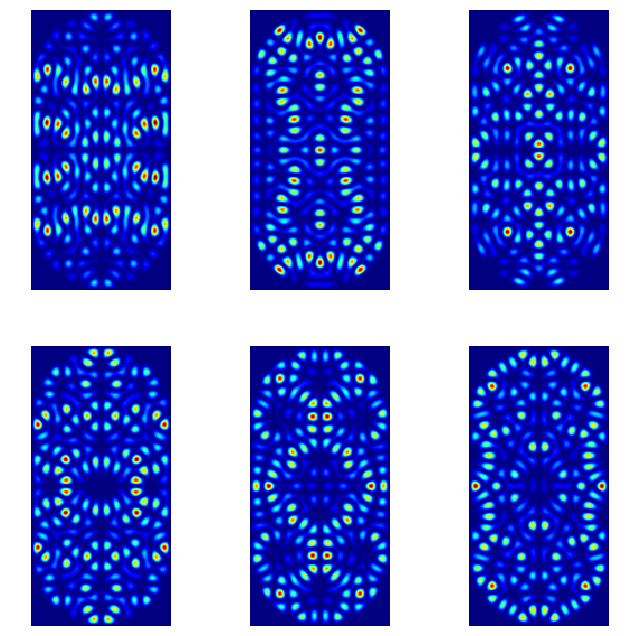

In [5]:
stadium_wavefunctions_plot()

## Visualizing the 2D Wavefunctions in 3D

By modifying the potential energy _V_, we can calculate the eigen-energies and wave functions of other systems. For example, the image below shows the 2 dimensional plot of |__Ψ__|<sup>2</sup> for a circular corral (the "3rd" dimension is the quantum probability and not a spatial dimension!). The largest probability of finding the particle is right in the centre of the corral!

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/schrodinger_eq_3d_c.png?raw=True" alt="drawing" width="300"/>

***

## My recommended books to learn more about Quantum Mechanics:
(I am in no way related or affiliated to the links provided!)

* <a href="https://www.amazon.com/Introduction-Quantum-Mechanics-David-Griffiths/dp/1107179866" target="_blank">Introduction to Quantum Mechanics</a>, D. J. Griffiths - this book is a great book for those who do not have an advanced physics background. Also this book has a picture of a cat on the cover!

* <a href="https://www.amazon.com/Quantum-Mechanics-2nd-B-H-Bransden/dp/0582356911" target="_blank">Quantum Mechanics</a>, B. H. Bransden and C. J. Joachain - for the more advanced people, I would recommend this introductory book which is more thorough and detailed mathematically. Unfortunately no cats on the cover.